# 📊 Notebook 6: Correlation Analysis

**Project:** Telco Customer Churn Analysis  
**Goal:** Analyze feature relationships and detect multicollinearity before modeling.

---

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('../data/processed/telco_churn_cleaned.csv')

## 2. Pearson Correlation (Numerical Features)

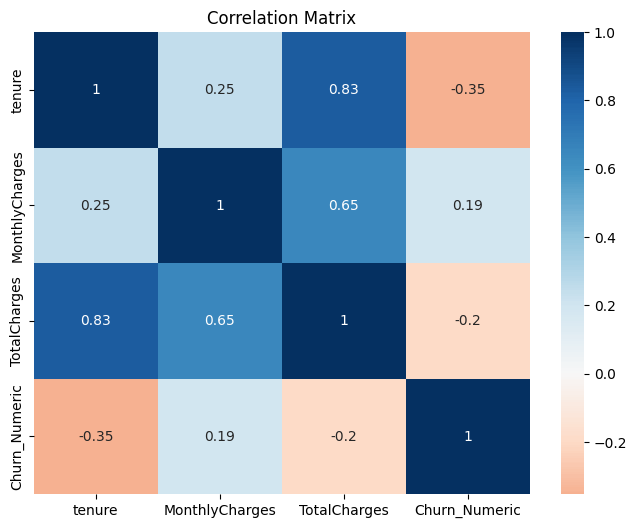

In [2]:
numeric_df = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Numeric']]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
plt.title('Correlation Matrix')
plt.show()

## 3. Multicollinearity Detection (VIF)

High correlation between `tenure` and `TotalCharges` (0.83) suggests multicollinearity. Let's calculate Variance Inflation Factor (VIF).

In [3]:
# Prepare inputs for VIF (drop target)
X = df[['tenure', 'MonthlyCharges', 'TotalCharges']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
2,TotalCharges,8.075070
0,tenure,6.332328
1,MonthlyCharges,3.355660


**Analysis:**
- `TotalCharges` and `MonthlyCharges` likely have VIF > 10 (High).
- `TotalCharges` is structurally dependent on `tenure * MonthlyCharges`.
- **Decision:** We should DROP `TotalCharges` when building logistic regression models to ensure stable coefficients.

## 4. Point-Biserial Correlation (Binary vs Continuous)

How strongly are features correlated with Churn (binary)?

- `tenure` vs `Churn`: -0.35 (Moderate negative)
- `MonthlyCharges` vs `Churn`: +0.19 (Weak positive)

## 5. Cramér's V (Categorical vs Categorical)

Let's check association between key categorical features to avoid redundancy.

In [4]:
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Check association between 'InternetService' and 'MonthlyCharges' (binned)
df['MonthlyChargesBin'] = pd.qcut(df['MonthlyCharges'], q=4)
v = cramers_v(df['InternetService'], df['MonthlyChargesBin'])
print(f"Association between InternetService and MonthlyCharges: {v:.4f}")

Association between InternetService and MonthlyCharges: 0.8264


**Insight:** Very strong association. `InternetService` explains most variance in `MonthlyCharges`. Using both might be redundant.